# 走神司机检测
本项目的数据来源是kaggle走神司机项目的[数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)。该数据集包含了10种类别的司机驾驶中的行为。为了简化处理，本项目已经将所有的数据下载并解压到跟本文件同目录，之后的所有操作建立在如下目录结构基础上：<br>
├── distracted_driver_detection.ipynb<br>
├── driver_imgs_list.csv<br>
└── imgs<br>
 &emsp;&emsp;├──test [79726 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── ...jpg<br>
 &emsp;&emsp;└──train [22423 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c0 [2489 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c1 [2267 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c2 [2317 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c3 [2346 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c4 [2326 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c5 [2312 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c6 [2325 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c7 [2002 images]<br>
 &emsp;&emsp; &emsp;&emsp;├── c8 [1911 images]<br>
 &emsp;&emsp; &emsp;&emsp;└── c9 [2129 images]<br>
├── cache [.h5 files] <br>
└── subm [.csv file]<br>

## 数据探索

In [1]:
import numpy as np
import os
import glob
import cv2
import pickle
import datetime
import pandas as pd
import time
import shutil
import warnings
warnings.filterwarnings("ignore")
np.random.seed(2018)
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Activation, Flatten,GlobalAveragePooling2D
from keras.optimizers import SGD,Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from PIL import *
import random
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.resnet50 import preprocess_input as res50_preprocess_input
from keras.applications.inception_resnet_v2 import preprocess_input as inres2_preprocess_input
%matplotlib inline

c:\users\mrxue\appdata\local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
# 读取csv数据
sns.set(color_codes=True)#导入seaborn包设定颜色
driver_image_lists = pd.read_csv('driver_imgs_list.csv')
driver_image_lists.tail()

,subject,classname,img
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg
22423,p081,c9,img_9684.jpg


In [21]:
# 探索不同类别数据的分布
classname_transfer = driver_image_lists['classname'].str[1:].astype('float32')

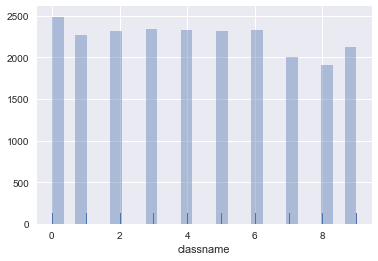

In [22]:
ax=sns.distplot(classname_transfer, kde=False, rug=True)

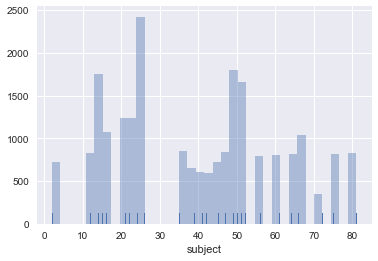

In [3]:
# 探索不同类别数据的分布
subject_transfer = driver_image_lists['subject'].str[1:].astype('float32')
ax2 = sns.distplot(subject_transfer,kde=False,rug=True)

## 数据获取 

In [3]:
# 利用keras内置的库函数读取，输出图像RGB信息，默认读取单个图像的信息维度为224x224x3
def get_img(path,size=(224,224)):
    img = image.load_img(path, target_size=size)
    x = image.img_to_array(img)
    return x

In [4]:
# 利用cv2读取，输出图像BGR信息，读取单个图像的信息维度为224x224x3
def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    return resized

In [5]:
# 获取司机视角的信息，返回图像和司机的一一映射，以及司机为key，图像和分类为value的映射
def get_driver_data():
    dr = dict()
    clss = dict()
    path = os.path.join('driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

In [6]:
# 载入所有原始训练集数据，返回各图像RGB信息，分类信息，图像唯一标识，图像司机id构成的数组，以及去重后的所有司机id数组
def load_train_data(size=(224,224)):
    X_train = []
    X_train_id = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data, dr_class = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join('imgs', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_img(fl,size)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, X_train_id, driver_id, unique_drivers

In [7]:
def split_list(l, wanted_parts=1):
    length = len(l)
    return [l[i*length // wanted_parts: (i+1)*length // wanted_parts] for i in range(wanted_parts)]

In [8]:
# 获取测试集数据
def load_test_data(part,size=(224,224)):
    path = os.path.join('imgs', 'test', '*.jpg')
    files = sorted(glob.glob(path))
    ch = split_list(files,10)
    X_test = []
    X_test_id = []
    print('Start image: ' + str(ch[part][0]))
    print('Last image: ' + str(ch[part][-1]))
    for fl in ch[part]:
        flbase = os.path.basename(fl)
        img = get_img(fl,size)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

In [9]:
# 载入训练数据并进行预处理
def read_train_data(size=(224,224)):
    start_time = time.time()
    train_data, train_target, train_id, driver_id, unique_drivers = load_train_data(size)
    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    print('OneHotEncode...')
    train_target = np_utils.to_categorical(train_target,10)
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    print('Target shape:', train_target.shape)
    print(train_target.shape[0], 'target samples')
    print('Read and process train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return train_data, train_target, train_id, driver_id, unique_drivers

In [10]:
# 载入测试数据并进行预处理
def read_test_data(part,size=(224,224)):
    start_time = time.time()
    test_data, test_id = load_test_data(part,size)
    test_data = np.array(test_data, dtype=np.uint8)
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_id

## 数据缓存

In [11]:
# 缓存数据
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [12]:
#　恢复数据
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

## 构建模型
利用预训练模型构建本项目模型

In [13]:
def vgg16_model():
    input_tensor = Input(shape=(224, 224, 3))
    imagenet_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    if os.path.isfile(imagenet_weight_path):
        base_model = VGG16(input_tensor=input_tensor,weights=imagenet_weight_path,include_top=False)
    else:
        base_model = VGG16(input_tensor=input_tensor,weights='imagenet',include_top=False)
    x = base_model.output
    # 全局平均池化
    x = GlobalAveragePooling2D()(x)
    # 全连接
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10,activation='softmax')(x)
    model = Model(inputs=base_model.input,outputs=predictions)
    adam = Adam(lr=1e-5)
    model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [14]:
def vgg19_model():
    input_tensor = Input(shape=(224, 224, 3))
    imagenet_weight_path = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    if os.path.isfile(imagenet_weight_path):
        base_model = VGG19(input_tensor=input_tensor,weights=imagenet_weight_path,include_top=False)
    else:
        base_model = VGG19(input_tensor=input_tensor,weights='imagenet',include_top=False)
    x = base_model.output
    # 全局平均池化
    x = GlobalAveragePooling2D()(x)
    # 全连接
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096,activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10,activation='softmax')(x)
    model = Model(inputs=base_model.input,outputs=predictions)
    adam = Adam(lr=1e-5)
    model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [15]:
def res50_model():
    input_tensor = Input(shape=(224, 224, 3))
    imagenet_weight_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    if os.path.isfile(imagenet_weight_path):
        base_model = ResNet50(input_tensor=input_tensor,weights=imagenet_weight_path,include_top=False)
    else:
        base_model = ResNet50(input_tensor=input_tensor,weights='imagenet',include_top=False)
    x = base_model.output
    # 全局平均池化
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(10,activation='softmax')(x)
    model = Model(inputs=base_model.input,outputs=predictions)
    adam = Adam(lr=1e-5)
    model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [18]:
# 在一种训练集上做训练
def train_model(model,modelname,foldnum,X_train,y_train,X_valid,y_valid,epochs,batchsize):
    start_time = time.time()
    weights_path = os.path.join('cache','weights_'+modelname+'_'+str(foldnum)+'.h5')
    if not os.path.isfile(weights_path):
        print('First train on dataset '+str(foldnum))
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, verbose=0),
            ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, verbose=0)
        ]
        model.fit(X_train, y_train, batch_size=batchsize, nb_epoch=epochs,
                  shuffle=True, verbose=1, validation_data=(X_valid, y_valid),
                  callbacks=callbacks)
    if os.path.isfile(weights_path):
        print('dataset already trained, loading weight...')
        model.load_weights(weights_path)
        print('model weight loaded')
    predictions_valid = model.predict(X_valid, batch_size=batchsize, verbose=1)
    score = log_loss(y_valid, predictions_valid)
    print('Score log_loss: ', score)
    end_time = time.time()
    train_time = round(end_time - start_time,2)
    print('Finish train fold '+str(foldnum)+' data, total time: '+str(train_time)+' seconds')
    pass

## 训练模型
KFold划分原始训练集为新的训练集和验证集，按照司机进行划分，然后做训练

In [19]:
# 从原始数据集中拷贝指定司机的图像数据，构建训练集和验证集的特征和标签数据
def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
    data = np.array(data)
    target = np.array(target)
    return data, target

In [20]:
# 由于内存限制，需要每进行一次分割，就要进行训练，而不是等所有分割完成之后再做训练，这里利用内置的预处理函数做预处理
def kfold_train_with_preprocess_input(epochs,batchsize,modelname,nfolds=10):
    if modelname not in ['vgg16','vgg19','res50']:
        print('Please set model name with vgg16 or vgg19 or res50')
        return False
    random_state = 51
    train_data, train_target, train_id, driver_id, unique_drivers = read_train_data()
    kf = KFold(len(unique_drivers),n_folds=nfolds,shuffle=True,random_state=random_state)
    num_fold = 0
    for train_drivers,valid_drivers in kf:
        num_fold += 1
        print('Start split '+ str(num_fold)+' train and valid data...')
        unique_train_drivers = [unique_drivers[i] for i in train_drivers]
        X_train,y_train = copy_selected_drivers(train_data,train_target,driver_id,unique_train_drivers)
        unique_valid_drivers = [unique_drivers[i] for i in valid_drivers]
        X_valid,y_valid = copy_selected_drivers(train_data,train_target,driver_id,unique_valid_drivers)
        print('Finish split '+ str(num_fold)+' train and valid data...')
        X_train = X_train.astype('float16')
        X_valid = X_valid.astype('float16')
        if modelname=='vgg16':
            model = vgg16_model()
            X_train = vgg16_preprocess_input(X_train)
            X_valid = vgg16_preprocess_input(X_valid)
        elif modelname == 'vgg19':
            model = vgg19_model()
            X_train = vgg19_preprocess_input(X_train)
            X_valid = vgg19_preprocess_input(X_valid)
        elif modelname == 'res50':
            model = res50_model()
            X_train = res50_preprocess_input(X_train)
            X_valid = res50_preprocess_input(X_valid)
        else:
            print('Please set model name with vgg16 or vgg19 or res50')
            return False
        print('X_train shape is :',X_train.shape)
        print('X_valid shape is :',X_valid.shape)
        print('Start train process on split dataset number:'+str(num_fold))
        train_model(model,modelname,num_fold,X_train,y_train,X_valid,y_valid,epochs,batchsize)
        print('Finish train process on split dataset number:'+str(num_fold))

In [21]:
# 由于内存限制，需要每进行一次分割，就要进行训练，而不是等所有分割完成之后再做训练，这里应用减imagenet均值做预处理
def build_kfold_dataset_and_train(epochs,batchsize,nfolds=10):
    random_state = 51
    train_data, train_target, train_id, driver_id, unique_drivers = read_train_data()
    kf = KFold(len(unique_drivers),n_folds=nfolds,shuffle=True,random_state=random_state)
    num_fold = 0
    for train_drivers,valid_drivers in kf:
        num_fold += 1
        # 针对每一个训练集创建模型，最后训练出来了k个模型
        model = vgg16_model()
        print('Start split '+ str(num_fold)+' train and valid data...')
        unique_train_drivers = [unique_drivers[i] for i in train_drivers]
        X_train,y_train = copy_selected_drivers(train_data,train_target,driver_id,unique_train_drivers)
        unique_valid_drivers = [unique_drivers[i] for i in valid_drivers]
        X_valid,y_valid = copy_selected_drivers(train_data,train_target,driver_id,unique_valid_drivers)
        print('Finish split '+ str(num_fold)+' train and valid data...')
        
        # 对于X_trainn和X_val，进行减均值预处理
        X_train = X_train.transpose(0,3,1,2)
        X_train = X_train.astype('float16')
        X_train[:,0,:,:] -= imagenet_mean_bgr[0]
        X_train[:,1,:,:] -= imagenet_mean_bgr[1]
        X_train[:,2,:,:] -= imagenet_mean_bgr[2]
        X_train = X_train.transpose(0,2,3,1)
        print('X_train shape is :',X_train.shape)
        X_valid = X_valid.transpose(0,3,1,2)
        X_valid = X_valid.astype('float16')
        X_valid[:,0,:,:] -= imagenet_mean_bgr[0]
        X_valid[:,1,:,:] -= imagenet_mean_bgr[1]
        X_valid[:,2,:,:] -= imagenet_mean_bgr[2]
        X_valid = X_valid.transpose(0,2,3,1)
        print('X_valid shape is :',X_valid.shape)
        print('Start train process on split dataset number:'+str(num_fold))
        train_model(model,num_fold,X_train,y_train,X_valid,y_valid,epochs,batchsize)
        print('Finish train process on split dataset number:'+str(num_fold))

## 预测测试集
利用训练好的模型在测试集上做预测，对k个分类器取平均结果作为最终的预测结果

In [22]:
# 返回K组预测平均值
def predict_mean(data,nfolds):
    first_fold = np.array(data[0])
    for i in range(1,nfolds):
        first_fold += np.array(data[i])
    first_fold /= nfolds
    return first_fold.tolist()

In [23]:
def append_chunk(main,part):
    for p in part:
        main.append(p)
    return main

In [24]:
# 应用内置的preprocess_input对测试数据预处理后做预测
def predict_test_data_preprocess_input(modelname,nfolds=10):
    if modelname not in ['vgg16','vgg19','res50']:
        print('Please set model name with vgg16 or vgg19 or res50')
        return False
    if modelname=='vgg16':
        model = vgg16_model()
    elif modelname == 'vgg19':
        model = vgg19_model()
    elif modelname == 'res50':
        model = res50_model()
    num_fold = 0
    prediction_list = []
    testid_list = []
    testid_cache_path = os.path.join('cache','testid_list.h5')
    for i in range(nfolds):
        num_fold = num_fold+1
        weights_path = os.path.join('cache','weights_'+modelname+'_'+str(num_fold)+'.h5')
        if not os.path.isfile(weights_path):
            print(weights_path+' File not exists')
            return false
        start = time.time()
        print('Start predict with model fold: '+str(num_fold))
        model.load_weights(weights_path)
        test_prediction_cache_path = os.path.join('cache','test_prediction_'+modelname+'_'+str(num_fold)+'.h5')
        if not os.path.isfile(test_prediction_cache_path):
            prediction = []
            # 测试数据分批读入、预处理、预测
            for part in range(10):
                print('Reading test data part {}...'.format(part))
                test_data_chunk, test_id_chunk = read_test_data(part)
                # 测试数据预处理方式与训练集一致
                test_data_chunk = test_data_chunk.astype('float16')
                if modelname == 'vgg16':
                    test_data_chunk = vgg16_preprocess_input(test_data_chunk)
                elif modelname == 'vgg19':
                    test_data_chunk = vgg19_preprocess_input(test_data_chunk)
                elif modelname == 'res50':
                    test_data_chunk = res50_preprocess_input(test_data_chunk)
                print('Start predict test data part {} ...'.format(part))
                prediction_part = model.predict(test_data_chunk)
                print('Finish predict test data part {} ...'.format(part))
                prediction = append_chunk(prediction,prediction_part)
                if i == 0:
                    testid_list = append_chunk(testid_list,test_id_chunk)
                    cache_data(testid_list,testid_cache_path)
            cache_data(prediction,test_prediction_cache_path)
            prediction_list.append(prediction)
        elif not os.path.isfile(testid_cache_path):
            for part in range(10):
                print('Reading test data part {}...'.format(part))
                test_data_chunk, test_id_chunk = read_test_data(part)
                if i == 0:
                    testid_list = append_chunk(testid_list,test_id_chunk)
                    cache_data(testid_list,testid_cache_path)
            print('Start restore test predict data '+str(num_fold))
            prediction = restore_data(test_prediction_cache_path)
            print('prediction size:',len(prediction),len(prediction[0]))
            prediction_list.append(prediction)
            print('prediction_list size:',len(prediction_list),len(prediction_list[0]))
        else:
            print('Start restore test predict data '+str(num_fold))
            prediction = restore_data(test_prediction_cache_path)
            print('prediction size:',len(prediction),len(prediction[0]))
            prediction_list.append(prediction)
            print('prediction_list size:',len(prediction_list),len(prediction_list[0]))
            if i == 0:
                print('Start restore testids')
                testid_list = restore_data(testid_cache_path)
                print('testid_list size:',len(testid_list))
        end_time = time.time()
        predict_time = round(end_time - start,2)
        print('Finish predict with model fold '+str(num_fold)+' , total time: '+str(predict_time)+' seconds')
    print('prediction list generated')
    return prediction_list,testid_list

In [25]:
# 利用K组训练好的权重对测试数据做预测，并返回测试结果
def predict_test_data(model,nfolds=10):
    num_fold = 0
    prediction_list = []
    testid_list = []
    testid_cache_path = os.path.join('cache','testid_list.h5')
    for i in range(nfolds):
        num_fold = num_fold+1
        weights_path = os.path.join('cache','weights_vgg16_'+str(num_fold)+'.h5')
        if not os.path.isfile(weights_path):
            print(weights_path+' File not exists')
            return false
        start = time.time()
        print('Start predict with model fold: '+str(num_fold))
        model.load_weights(weights_path)
        test_prediction_cache_path = os.path.join('cache','test_prediction_vgg16_'+str(num_fold)+'.h5')
        if not os.path.isfile(test_prediction_cache_path):
            prediction = []
            # 测试数据分批读入、预处理、预测
            for part in range(10):
                print('Reading test data part {}...'.format(part))
                test_data_chunk, test_id_chunk = read_test_data(part)
                # 测试数据预处理方式与训练集一致
                test_data_chunk = test_data_chunk.transpose(0,3,1,2)
                test_data_chunk = test_data_chunk.astype('float16')
                test_data_chunk[:,0,:,:] -= imagenet_mean_bgr[0]
                test_data_chunk[:,1,:,:] -= imagenet_mean_bgr[1]
                test_data_chunk[:,2,:,:] -= imagenet_mean_bgr[2]
                test_data_chunk = test_data_chunk.transpose(0,2,3,1)
                print('Start predict test data part {} ...'.format(part))
                prediction_part = model.predict(test_data_chunk)
                print('Finish predict test data part {} ...'.format(part))
                prediction = append_chunk(prediction,prediction_part)
                if i == 0:
                    testid_list = append_chunk(testid_list,test_id_chunk)
                    cache_data(testid_list,testid_cache_path)
            cache_data(prediction,test_prediction_cache_path)
            prediction_list.append(prediction)
        elif not os.path.isfile(testid_cache_path):
            for part in range(10):
                print('Reading test data part {}...'.format(part))
                test_data_chunk, test_id_chunk = read_test_data(part)
                if i == 0:
                    testid_list = append_chunk(testid_list,test_id_chunk)
                    cache_data(testid_list,testid_cache_path)
            print('Start restore test predict data '+str(num_fold))
            prediction = restore_data(test_prediction_cache_path)
            print('prediction size:',len(prediction),len(prediction[0]))
            prediction_list.append(prediction)
            print('prediction_list size:',len(prediction_list),len(prediction_list[0]))
        else:
            print('Start restore test predict data '+str(num_fold))
            prediction = restore_data(test_prediction_cache_path)
            print('prediction size:',len(prediction),len(prediction[0]))
            prediction_list.append(prediction)
            print('prediction_list size:',len(prediction_list),len(prediction_list[0]))
            if i == 0:
                print('Start restore testids')
                testid_list = restore_data(testid_cache_path)
                print('testid_list size:',len(testid_list))
        end_time = time.time()
        predict_time = round(end_time - start,2)
        print('Finish predict with model fold '+str(num_fold)+' , total time: '+str(predict_time)+' seconds')
    print('prediction list generated')
    return prediction_list,testid_list

## 生成提交数据
对预测结果进一步处理，并写入到csv文件中，以便提交至kaggle

In [26]:
def create_submission(predictions,testid_list,filename,submit_file_path='subm'):
    # 为了避免极端值，进行数据裁剪
    predictions = predictions.clip(min=1e-15,max=(1-1e-15))
    df = pd.DataFrame(np.array(predictions),columns=['c'+str(i) for i in range(10)])
    df.insert(0,'img',testid_list)
    path = os.path.join(submit_file_path,filename)
    df.to_csv(path,index=None)
    print('Create submit file finished')

## 模型调优

In [23]:
if not os.path.isdir('cache'):
    os.mkdir('cache')
if not os.path.isdir('subm'):
    os.mkdir('subm')

In [24]:
# vgg使用adam,lr=1e-5时的表现
build_kfold_dataset_and_train(10,16)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 74.85 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 76.8 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
First train on dataset 1
Train on 20201 samples, validate on 2223 samples
Epoch 1/10
20201/20201 [==============================] - 276s 14ms/step - loss: 0.8050 - 

In [27]:
# vgg使用adam，lr=1e-6时的表现
build_kfold_dataset_and_train(10,16)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 75.91 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 77.99 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
First train on dataset 1
Train on 20201 samples, validate on 2223 samples
Epoch 1/10
20201/20201 [==============================] - 275s 14ms/step - loss: 2.3902 -

In [32]:
# vgg使用adam,lr=1e-5，训练10个分类器
build_kfold_dataset_and_train(10,16)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 84.44 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 87.71 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
dataset already trained, loading weight...
model weight loaded
2223/2223 [==============================] - 9s 4ms/step
Score log_loss:  1.01232579669
Finish train

X_valid shape is : (1854, 224, 224, 3)
Start train process on split dataset number:7
First train on dataset 7
Train on 20570 samples, validate on 1854 samples
Epoch 1/10
20570/20570 [==============================] - 280s 14ms/step - loss: 0.7562 - acc: 0.7373 - val_loss: 0.8138 - val_acc: 0.7497
Epoch 2/10
20570/20570 [==============================] - 278s 14ms/step - loss: 0.0502 - acc: 0.9862 - val_loss: 0.6752 - val_acc: 0.7745
Epoch 3/10
20570/20570 [==============================] - 278s 13ms/step - loss: 0.0269 - acc: 0.9935 - val_loss: 0.8758 - val_acc: 0.7810
Epoch 4/10
20570/20570 [==============================] - 277s 13ms/step - loss: 0.0124 - acc: 0.9964 - val_loss: 0.9175 - val_acc: 0.7708
Epoch 5/10
20570/20570 [==============================] - 277s 13ms/step - loss: 0.0163 - acc: 0.9952 - val_loss: 0.7481 - val_acc: 0.7789
Epoch 6/10
20570/20570 [==============================] - 277s 13ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 0.8419 - val_acc: 0.7794
Epoch 7

In [23]:
# adam,1e-6 performance
build_kfold_dataset_and_train(10,16)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 75.08 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 77.0 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
dataset already trained, loading weight...
model weight loaded
2223/2223 [==============================] - 11s 5ms/step
Score log_loss:  0.680103623704
Finish trai

Train on 20820 samples, validate on 1604 samples
Epoch 1/10
20820/20820 [==============================] - 281s 14ms/step - loss: 2.3684 - acc: 0.1439 - val_loss: 2.1687 - val_acc: 0.2643
Epoch 2/10
20820/20820 [==============================] - 279s 13ms/step - loss: 1.4939 - acc: 0.4890 - val_loss: 1.1311 - val_acc: 0.6733
Epoch 3/10
20820/20820 [==============================] - 279s 13ms/step - loss: 0.4594 - acc: 0.8627 - val_loss: 1.0509 - val_acc: 0.7276
Epoch 4/10
20820/20820 [==============================] - 279s 13ms/step - loss: 0.2235 - acc: 0.9335 - val_loss: 1.0763 - val_acc: 0.7444
Epoch 5/10
20820/20820 [==============================] - 279s 13ms/step - loss: 0.1353 - acc: 0.9614 - val_loss: 0.9620 - val_acc: 0.8086
Epoch 6/10
20820/20820 [==============================] - 279s 13ms/step - loss: 0.0915 - acc: 0.9748 - val_loss: 1.1451 - val_acc: 0.7544
Epoch 7/10
20820/20820 [==============================] - 279s 13ms/step - loss: 0.0601 - acc: 0.9835 - val_loss: 1.1

In [55]:
# 利用adam 1e-6时得到的10个分类器做预测
prediction_list,testid_list = predict_test_data(vgg16_model())

Start predict with model fold: 1
Start restore test predict data 1
prediction size: 79726 10
prediction_list size: 1 79726
Start restore testids
testid_list size: 79726
Finish predict with model fold 1 , total time: 2.09 seconds
Start predict with model fold: 2
Start restore test predict data 2
prediction size: 79726 10
prediction_list size: 2 79726
Finish predict with model fold 2 , total time: 0.33 seconds
Start predict with model fold: 3
Start restore test predict data 3
prediction size: 79726 10
prediction_list size: 3 79726
Finish predict with model fold 3 , total time: 0.32 seconds
Start predict with model fold: 4
Start restore test predict data 4
prediction size: 79726 10
prediction_list size: 4 79726
Finish predict with model fold 4 , total time: 0.33 seconds
Start predict with model fold: 5
Start restore test predict data 5
prediction size: 79726 10
prediction_list size: 5 79726
Finish predict with model fold 5 , total time: 0.33 seconds
Start predict with model fold: 6
Start 

In [24]:
# 利用adam 1e-5 得到的10个分类器做预测
prediction_list,testid_list = predict_test_data(vgg16_model())

Start predict with model fold: 1
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 26.75 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 26.72 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 26.76 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start image: imgs\test\img_35667.jpg
Last image: imgs\test\img_44886.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and proces

Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 3 , total time: 689.49 seconds
Start predict with model fold: 4
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 26.73 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 26.73 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 26.73 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start

Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 26.74 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 6 , total time: 689.62 seconds
Start predict with model fold: 7
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 26.76 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 26.72 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 26.73 seconds
Start p

Finish predict test data part 8 ...
Reading test data part 9...
Start image: imgs\test\img_90857.jpg
Last image: imgs\test\img_99999.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 26.73 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 9 , total time: 689.18 seconds
Start predict with model fold: 10
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 26.72 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 27.14 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
La

In [30]:
# vgg16,1e-5，应用正确的preprocess_input,没有增强
kfold_train_with_preprocess_input(10,16,'vgg16')

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 84.95 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 90.17 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
First train on dataset 1
Train on 20201 samples, validate on 2223 samples
Epoch 1/10
20201/20201 [==============================] - 281s 14ms/step - loss: 0.7699 -

In [33]:
# 继续后边8个划分的训练，看看会不会有更好的效果
kfold_train_with_preprocess_input(10,16,'vgg16')

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 80.55 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 85.28 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
dataset already trained, loading weight...
model weight loaded
2223/2223 [==============================] - 10s 5ms/step
Score log_loss:  0.433557671139
Finish tra

In [40]:
# 应用正确的proprecess_input,利用adam 1e-5 得到的10个分类器做预测
prediction_list_vgg16,testid_list_vgg16 = predict_test_data_preprocess_input('vgg16')

Start predict with model fold: 1
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 31.69 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 33.46 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 33.11 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start image: imgs\test\img_35667.jpg
Last image: imgs\test\img_44886.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and proces

Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 3 , total time: 758.08 seconds
Start predict with model fold: 4
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 31.48 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 31.73 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 31.34 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start

Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 31.77 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 6 , total time: 758.88 seconds
Start predict with model fold: 7
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 31.43 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 31.67 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 31.49 seconds
Start p

Finish predict test data part 8 ...
Reading test data part 9...
Start image: imgs\test\img_90857.jpg
Last image: imgs\test\img_99999.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 31.79 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 9 , total time: 760.09 seconds
Start predict with model fold: 10
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 31.79 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 31.57 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
La

In [27]:
# 利用vgg19做训练
kfold_train_with_preprocess_input(10,16,'vgg19')

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 79.78 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 84.96 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
First train on dataset 1
Train on 20201 samples, validate on 2223 samples
Epoch 1/10
20201/20201 [==============================] - 332s 16ms/step - loss: 0.8666 -

In [30]:
# 利用res50做训练
kfold_train_with_preprocess_input(10,16,'res50')

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 80.55 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 89.83 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
First train on dataset 1
Train on 20201 samples, validate on 2223 samples
Epoch 1/10
20201/20201 [==============================] - 260s 13ms/step - loss: 0.3780 -

In [32]:
# 利用vgg19训练其他8个分类器
kfold_train_with_preprocess_input(10,16,'vgg19')

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 90.56 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 95.83 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
dataset already trained, loading weight...
model weight loaded
2223/2223 [==============================] - 12s 5ms/step
Score log_loss:  0.612414051226
Finish tra

In [27]:
# 利用res50训练其他8个分类器
kfold_train_with_preprocess_input(10,16,'res50')

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 78.97 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Convert to numpy...
OneHotEncode...
Train shape: (22424, 224, 224, 3)
22424 train samples
Target shape: (22424, 10)
22424 target samples
Read and process train data time: 84.21 seconds
Start split 1 train and valid data...
Finish split 1 train and valid data...
X_train shape is : (20201, 224, 224, 3)
X_valid shape is : (2223, 224, 224, 3)
Start train process on split dataset number:1
dataset already trained, loading weight...
model weight loaded
2223/2223 [==============================] - 11s 5ms/step
Score log_loss:  0.523393131913
Finish tra

In [28]:
# 利用训练好的vgg19做预测
prediction_list_vgg19,testid_list_vgg19 = predict_test_data_preprocess_input('vgg19')

Start predict with model fold: 1
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 42.2 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 39.89 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 39.64 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start image: imgs\test\img_35667.jpg
Last image: imgs\test\img_44886.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process

Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 3 , total time: 882.48 seconds
Start predict with model fold: 4
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.39 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 38.3 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.41 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start 

Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 38.29 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 6 , total time: 883.69 seconds
Start predict with model fold: 7
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.23 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 38.21 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.39 seconds
Start p

Finish predict test data part 8 ...
Reading test data part 9...
Start image: imgs\test\img_90857.jpg
Last image: imgs\test\img_99999.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 38.65 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 9 , total time: 884.35 seconds
Start predict with model fold: 10
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.58 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 38.66 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
La

In [29]:
# 利用训练好的res50做预测
prediction_list_res50,testid_list_res50 = predict_test_data_preprocess_input('res50')

Start predict with model fold: 1
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.99 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 39.01 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 39.15 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start image: imgs\test\img_35667.jpg
Last image: imgs\test\img_44886.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and proces

Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 3 , total time: 846.83 seconds
Start predict with model fold: 4
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.84 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 39.01 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 38.76 seconds
Start predict test data part 2 ...
Finish predict test data part 2 ...
Reading test data part 3...
Start

Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 39.2 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 6 , total time: 849.42 seconds
Start predict with model fold: 7
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 39.43 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 39.41 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 39.37 seconds
Start pr

Start image: imgs\test\img_90857.jpg
Last image: imgs\test\img_99999.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 39.12 seconds
Start predict test data part 9 ...
Finish predict test data part 9 ...
Finish predict with model fold 9 , total time: 851.16 seconds
Start predict with model fold: 10
Reading test data part 0...
Start image: imgs\test\img_1.jpg
Last image: imgs\test\img_17209.jpg
Test shape: (7972, 224, 224, 3)
7972 test samples
Read and process test data time: 39.18 seconds
Start predict test data part 0 ...
Finish predict test data part 0 ...
Reading test data part 1...
Start image: imgs\test\img_1721.jpg
Last image: imgs\test\img_26429.jpg
Test shape: (7973, 224, 224, 3)
7973 test samples
Read and process test data time: 39.06 seconds
Start predict test data part 1 ...
Finish predict test data part 1 ...
Reading test data part 2...
Start image: imgs\test\img_2643.jpg
Last image: imgs\test\img_35665.jpg
Test shape: (7972, 224, 224, 3

In [32]:
# 10个分类器的预测结果做平均,结果10平均最好
result_with10_vgg16 = predict_mean(prediction_list_vgg16,10)

In [33]:
result_with10_vgg19 = predict_mean(prediction_list_vgg19,10)

In [34]:
result_with10_res50 = predict_mean(prediction_list_res50,10)

In [35]:
result_with10_vgg16 = np.array(result_with10_vgg16)
result_with10_vgg16.shape

(79726, 10)

In [36]:
result_with10_vgg19 = np.array(result_with10_vgg19)
result_with10_vgg19.shape

(79726, 10)

In [37]:
result_with10_res50 = np.array(result_with10_res50)
result_with10_res50.shape

(79726, 10)

In [39]:
create_submission(result_with10_vgg16,testid_list_vgg16,'submission_10_vgg16.csv')

Create submit file finished


In [40]:
create_submission(result_with10_vgg19,testid_list_vgg19,'submission_10_vgg19.csv')

Create submit file finished


In [41]:
create_submission(result_with10_res50,testid_list_res50,'submission_10_res50.csv')

Create submit file finished


In [42]:
result_with10_3avg = (result_with10_vgg16+result_with10_vgg19+result_with10_res50)/3
result_with10_3avg.shape

(79726, 10)

In [43]:
create_submission(result_with10_3avg,testid_list_vgg16,'submission_10_3avg.csv')

Create submit file finished


In [45]:
result_with10_2avg_16_and19 = (result_with10_vgg16+result_with10_vgg19)/2
create_submission(result_with10_2avg_16_and19,testid_list_vgg16,'submission_10_2avg_16_and19.csv')

Create submit file finished


In [46]:
result_with10_2avg_16_and50 = (result_with10_vgg16+result_with10_res50)/2
create_submission(result_with10_2avg_16_and50,testid_list_vgg16,'submission_10_2avg_16_and50.csv')

Create submit file finished
